# SQL Database Query Pipeline

This notebook demonstrates setting up a query pipeline for interacting with a SQL database using natural language queries. It utilizes LlamaIndex for retrieval and OpenAI's language models for query processing.

## Setup and Imports
The code above imports necessary libraries and sets up the OpenAI API key.

In [1]:
from llama_index.query_engine.pandas import PandasInstructionParser
from llama_index.llms import OpenAI
from llama_index.prompts import PromptTemplate

In [2]:
import os

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# Preprocess data

In [10]:
import pandas as pd

df = pd.read_csv("transactions.csv")
df

,Customer ID,Name,Surname,Gender,Birthdate,Transaction Amount,Date,Merchant Name,Category
0,752858,Sean,Rodriguez,F,20-10-2002,35.47,03-04-2023,Smith-Russell,Cosmetic
1,26381,Michelle,Phelps,NaN,24-10-1985,2552.72,17-07-2023,"Peck, Spence and Young",Travel
2,305449,Jacob,Williams,M,25-10-1981,115.97,20-09-2023,Steele Inc,Clothing
3,988259,Nathan,Snyder,M,26-10-1977,11.31,11-01-2023,"Wilson, Wilson and Russell",Cosmetic
4,764762,Crystal,Knapp,F,02-11-1951,62.21,13-06-2023,Palmer-Hinton,Electronics
...,...,...,...,...,...,...,...,...,...
49995,891845,Christine,Leach,F,21-10-1997,108.74,30-08-2023,Alexander Ltd,Market
49996,800560,Anna,Allen,F,21-10-1999,133.66,03-05-2023,Knapp-Calhoun,Cosmetic
49997,133285,Nicole,Franklin,M,26-10-1979,464.29,12-02-2023,"Cantrell, Haynes and Ballard",Market
49998,616122,Maria,Keller,M,25-10-1981,472.57,25-03-2023,"Wilson, Jackson and Beard",Market


In [4]:
df.drop(['Customer ID', 'Birthdate'], inplace=True, axis=1)
df['Name'] = 'Ivan'
df['Surname'] = 'Ivanov'
df['Gender'] = 'M'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                50000 non-null  object 
 1   Surname             50000 non-null  object 
 2   Gender              50000 non-null  object 
 3   Transaction Amount  50000 non-null  float64
 4   Date                50000 non-null  object 
 5   Merchant Name       50000 non-null  object 
 6   Category            50000 non-null  object 
dtypes: float64(1), object(6)
memory usage: 2.7+ MB


## Query Pipeline Setup
The following sections set up various components of our query pipeline:
1. Table information extraction
2. SQL database connection
3. Vector index creation for efficient retrieval
4. Prompt templates for text-to-SQL conversion and response synthesis

In [6]:
from llama_index.program import LLMTextCompletionProgram
from llama_index.bridge.pydantic import BaseModel, Field
from llama_index.llms import OpenAI


class TableInfo(BaseModel):
    """Information regarding a structured table."""

    table_name: str = Field(
        ..., description="table name (must be underscores and NO spaces)"
    )
    table_summary: str = Field(
        ..., description="short, concise summary/caption of the table"
    )


prompt_str = """\
Give me a summary of the table with the following JSON format.

- The table name must be unique to the table and describe it while being concise.
- Do NOT output a generic table name (e.g. table, my_table).

Table:
{table_str}

Summary: """

program = LLMTextCompletionProgram.from_defaults(
    output_cls=TableInfo,
    llm=OpenAI(model="gpt-3.5-turbo"),
    prompt_template_str=prompt_str,
)

In [7]:
import json
from pathlib import Path

tableinfo_dir = 'table_info_directory'
!mkdir {tableinfo_dir}

def _get_tableinfo_with_index(idx: int) -> str:
    results_gen = Path(tableinfo_dir).glob(f"{idx}_*")
    
    results_list = list(results_gen)
    if len(results_list) == 0:
        return None
    elif len(results_list) == 1:
        path = results_list[0]
        return TableInfo.parse_file(path)
    else:
        raise ValueError(
            f"More than one file matching index: {list(results_gen)}"
        )

idx = 0

table_info = _get_tableinfo_with_index(idx)

df_str = df.head(10).to_csv()
table_info = program(
    table_str=df_str
)
table_name = table_info.table_name
print(f"Processed table: {table_name}")

out_file = f"{tableinfo_dir}/{idx}_{table_name}.json"
json.dump(table_info.dict(), open(out_file, "w"))

Processed table: Ivanov_Transactions
[TableInfo(table_name='Ivanov_Transactions', table_summary="Summary of Ivan Ivanov's transactions including gender, transaction amounts, dates, merchant names, and categories.")]


In [25]:
# put data into sqlite db
from sqlalchemy import (
    create_engine,
    MetaData,
    Table,
    Column,
    String,
    Integer,
)
import re

# Function to create a sanitized column name
def sanitize_column_name(col_name):
    # Remove special characters and replace spaces with underscores
    return re.sub(r"\W+", "_", col_name)

# Function to create a table from a DataFrame using SQLAlchemy
def create_table_from_dataframe(
    df: pd.DataFrame, table_name: str, engine, metadata_obj
):
    # Sanitize column names
    sanitized_columns = {col: sanitize_column_name(col) for col in df.columns}
    df = df.rename(columns=sanitized_columns)

    # Dynamically create columns based on DataFrame columns and data types
    columns = [
        Column(col, String if dtype == "object" else Integer)
        for col, dtype in zip(df.columns, df.dtypes)
    ]

    # Create a table with the defined columns
    table = Table(table_name, metadata_obj, *columns)

    # Create the table in the database
    metadata_obj.create_all(engine)

    # Insert data from DataFrame into the table
    with engine.connect() as conn:
        for _, row in df.iterrows():
            insert_stmt = table.insert().values(**row.to_dict())
            conn.execute(insert_stmt)
        conn.commit()


engine = create_engine("sqlite:///transactions.db")
metadata_obj = MetaData()
tableinfo = _get_tableinfo_with_index(idx)
print(f"Creating table: {tableinfo.table_name}")
create_table_from_dataframe(df, tableinfo.table_name, engine, metadata_obj)

Creating table: Ivanov_Transactions


# setup Arize Phoenix for tracing

In [28]:
import phoenix as px
import llama_index

px.launch_app()
llama_index.set_global_handler("arize_phoenix")

Existing running Phoenix instance detected! Shutting it down and starting a new instance...


🌍 To view the Phoenix app in your browser, visit http://127.0.0.1:6006/
📺 To view the Phoenix app in a notebook, run `px.active_session().view()`
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


## Query Pipeline Construction
Construct our query pipeline by adding modules and defining the links between them.


In [10]:
from llama_index.objects import (
    SQLTableNodeMapping,
    ObjectIndex,
    SQLTableSchema,
)
from llama_index import SQLDatabase, VectorStoreIndex

sql_database = SQLDatabase(engine)

table_node_mapping = SQLTableNodeMapping(sql_database)
table_schema_objs = [
    SQLTableSchema(table_name=table_info.table_name, context_str=table_info.table_summary)
]

obj_index = ObjectIndex.from_objects(
    table_schema_objs,
    table_node_mapping,
    VectorStoreIndex,
)
obj_retriever = obj_index.as_retriever(similarity_top_k=3)

In [11]:
from llama_index.retrievers import SQLRetriever
from typing import List
from llama_index.query_pipeline import FnComponent

sql_retriever = SQLRetriever(sql_database)


def get_table_context_str(table_schema_objs: List[SQLTableSchema]):
    """Get table context string."""
    context_strs = []
    for table_schema_obj in table_schema_objs:
        table_info = sql_database.get_single_table_info(
            table_schema_obj.table_name
        )
        if table_schema_obj.context_str:
            table_opt_context = " The table description is: "
            table_opt_context += table_schema_obj.context_str
            table_info += table_opt_context

        context_strs.append(table_info)
    return "\n\n".join(context_strs)

table_parser_component = FnComponent(fn=get_table_context_str)

In [12]:
from llama_index.prompts.default_prompts import DEFAULT_TEXT_TO_SQL_PROMPT
from llama_index.prompts import PromptTemplate
from llama_index.query_pipeline import FnComponent
from llama_index.llms import ChatResponse


def parse_response_to_sql(response: ChatResponse) -> str:
    """Parse response to SQL."""
    response = response.message.content
    sql_query_start = response.find("SQLQuery:")
    if sql_query_start != -1:
        response = response[sql_query_start:]
        if response.startswith("SQLQuery:"):
            response = response[len("SQLQuery:") :]
    sql_result_start = response.find("SQLResult:")
    if sql_result_start != -1:
        response = response[:sql_result_start]
    return response.strip().strip("```").strip()


sql_parser_component = FnComponent(fn=parse_response_to_sql)

text2sql_prompt = DEFAULT_TEXT_TO_SQL_PROMPT.partial_format(
    dialect=engine.dialect.name
)
print(text2sql_prompt.template)

Given an input question, first create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Pay attention to which column is in which table. Also, qualify column names with the table name when needed. You are required to use the following format, each taking one line:

Question: Question here
SQLQuery: SQL Query to run
SQLResult: Result of the SQLQuery
Answer: Final answer here

Only use tables listed below.
{schema}

Question: {query_str}
SQLQuery: 


In [13]:
response_synthesis_prompt_str = (
    "Given an input question, synthesize a response from the query results.\n"
    "Query: {query_str}\n"
    "SQL: {sql_query}\n"
    "SQL Response: {context_str}\n"
    "Response: "
)
response_synthesis_prompt = PromptTemplate(
    response_synthesis_prompt_str,
)

In [14]:
from llama_index.query_pipeline import QueryPipeline as QP
from llama_index.service_context import ServiceContext

qp = QP(verbose=False)
# NOTE: service context will be deprecated in v0.10 (though will still be backwards compatible)
service_context = ServiceContext.from_defaults(callback_manager=qp.callback_manager)

In [15]:
from llama_index import SQLDatabase, VectorStoreIndex, load_index_from_storage
from sqlalchemy import text
from llama_index.schema import TextNode
from llama_index.storage import StorageContext
import os
from pathlib import Path
from typing import Dict


def index_all_tables(
    sql_database: SQLDatabase, table_index_dir: str = "table_index_dir"
) -> Dict[str, VectorStoreIndex]:
    """Index all tables."""
    if not Path(table_index_dir).exists():
        os.makedirs(table_index_dir)

    vector_index_dict = {}
    engine = sql_database.engine
    for table_name in sql_database.get_usable_table_names():
        print(f"Indexing rows in table: {table_name}")
        if not os.path.exists(f"{table_index_dir}/{table_name}"):
            # get all rows from table
            with engine.connect() as conn:
                cursor = conn.execute(text(f'SELECT * FROM "{table_name}"'))
                result = cursor.fetchall()
                row_tups = []
                for row in result:
                    row_tups.append(tuple(row))

            # index each row, put into vector store index
            nodes = [TextNode(text=str(t)) for t in row_tups[:5]]

            # put into vector store index (use OpenAIEmbeddings by default)
            index = VectorStoreIndex(nodes, service_context=service_context)

            # save index
            index.set_index_id("vector_index")
            index.storage_context.persist(f"{table_index_dir}/{table_name}")
        else:
            # rebuild storage context
            storage_context = StorageContext.from_defaults(
                persist_dir=f"{table_index_dir}/{table_name}"
            )
            # load index
            index = load_index_from_storage(
                storage_context, index_id="vector_index", service_context=service_context
            )
        vector_index_dict[table_name] = index

    return vector_index_dict


vector_index_dict = index_all_tables(sql_database)

Indexing rows in table: Ivanov_Transactions


In [16]:
test_retriever = vector_index_dict['Ivanov_Transactions'].as_retriever(
    similarity_top_k=1
)
nodes = test_retriever.retrieve('Ivan')
print(nodes[0].get_content())

('Ivan', 'Ivanov', 'M', 35.47, '03-04-2023', 'Smith-Russell', 'Cosmetic')


In [17]:
from llama_index.retrievers import SQLRetriever
from typing import List
from llama_index.query_pipeline import FnComponent

sql_retriever = SQLRetriever(sql_database)


def get_table_context_and_rows_str(
    query_str: str, table_schema_objs: List[SQLTableSchema]
):
    """Get table context string."""
    context_strs = []
    for table_schema_obj in table_schema_objs:
        # first append table info + additional context
        table_info = sql_database.get_single_table_info(
            table_schema_obj.table_name
        )
        if table_schema_obj.context_str:
            table_opt_context = " The table description is: "
            table_opt_context += table_schema_obj.context_str
            table_info += table_opt_context

        # also lookup vector index to return relevant table rows
        vector_retriever = vector_index_dict[
            table_schema_obj.table_name
        ].as_retriever(similarity_top_k=2)
        relevant_nodes = vector_retriever.retrieve(query_str)
        if len(relevant_nodes) > 0:
            table_row_context = "\nHere are some relevant example rows (values in the same order as columns above)\n"
            for node in relevant_nodes:
                table_row_context += str(node.get_content()) + "\n"
            table_info += table_row_context

        context_strs.append(table_info)
    return "\n\n".join(context_strs)


table_parser_component = FnComponent(fn=get_table_context_and_rows_str)

In [18]:
from llama_index.query_pipeline import (
    InputComponent,
)

qp.add_modules({
    "input": InputComponent(),
    "table_retriever": obj_retriever,
    "table_output_parser": table_parser_component,
    "text2sql_prompt": text2sql_prompt,
    "text2sql_llm": llm,
    "sql_output_parser": sql_parser_component,
    "sql_retriever": sql_retriever,
    "response_synthesis_prompt": response_synthesis_prompt,
    "response_synthesis_llm": llm,
})

In [19]:
qp.add_link("input", "table_retriever")
qp.add_link("input", "table_output_parser", dest_key="query_str")
qp.add_link(
    "table_retriever", "table_output_parser", dest_key="table_schema_objs"
)
qp.add_link("input", "text2sql_prompt", dest_key="query_str")
qp.add_link("table_output_parser", "text2sql_prompt", dest_key="schema")
qp.add_chain(
    ["text2sql_prompt", "text2sql_llm", "sql_output_parser", "sql_retriever"]
)
qp.add_link(
    "sql_output_parser", "response_synthesis_prompt", dest_key="sql_query"
)
qp.add_link(
    "sql_retriever", "response_synthesis_prompt", dest_key="context_str"
)
qp.add_link("input", "response_synthesis_prompt", dest_key="query_str")
qp.add_link("response_synthesis_prompt", "response_synthesis_llm")

In [1]:
# from pyvis.network import Network

# net = Network(notebook=True, cdn_resources="in_line", directed=True)
# net.from_nx(qp.dag)
# net.show("text2sql_dag.html")

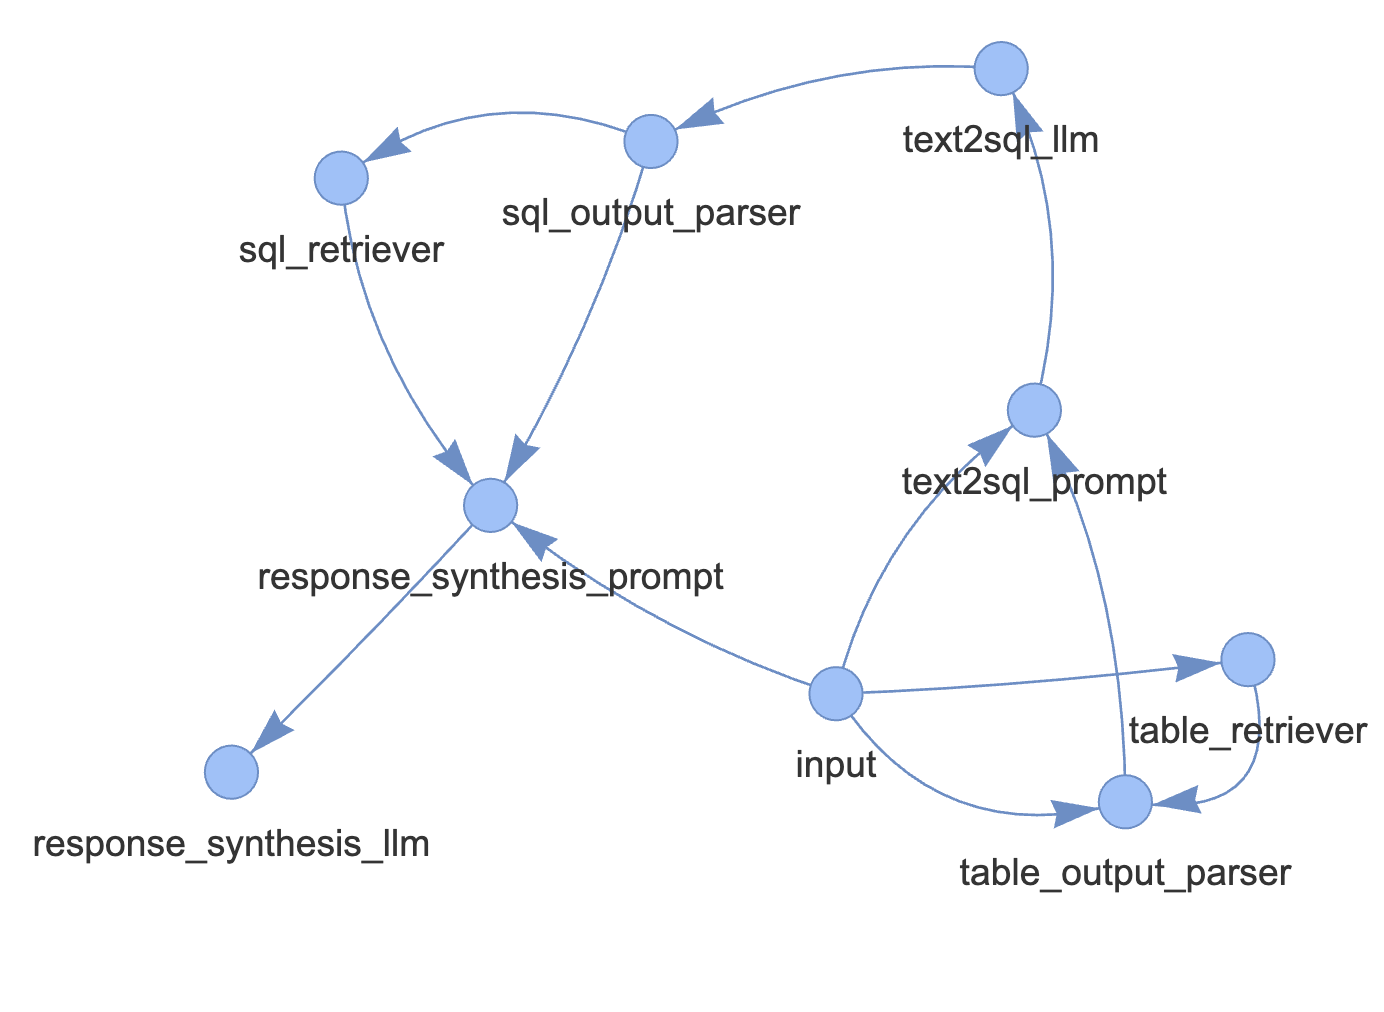

In [21]:
response = qp.run(
    query="How much did I spend on cosmetics in April of 2023?"
)
print(str(response))

> Running module input with input: 
query: How much did I spend on cosmetics in April of 2023?

> Running module table_retriever with input: 
input: How much did I spend on cosmetics in April of 2023?

> Running module table_output_parser with input: 
query_str: How much did I spend on cosmetics in April of 2023?
table_schema_objs: [SQLTableSchema(table_name='Ivanov_Transactions', context_str="Summary of Ivan Ivanov's transactions including gender, transaction amounts, dates, merchant names, and categories.")]

> Running module text2sql_prompt with input: 
query_str: How much did I spend on cosmetics in April of 2023?
schema: Table 'Ivanov_Transactions' has columns: Name (VARCHAR), Surname (VARCHAR), Gender (VARCHAR), Transaction_Amount (INTEGER), Date (VARCHAR), Merchant_Name (VARCHAR), Category (VARCHAR), and foreign key...

> Running module text2sql_llm with input: 
messages: Given an input question, first create a syntactically correct sqlite query to run, then look at the results 

In [23]:
df[(df['Category'] == 'Cosmetic') & (df['Date'].str.startswith('04-')) & (df['Date'].str.endswith('-2023'))]['Transaction Amount'].sum()
# nice

29981.65

In [ ]:
from llama_index.objects import (
    SQLTableNodeMapping,
    ObjectIndex,
    SQLTableSchema,
)
from llama_index import SQLDatabase, VectorStoreIndex


class TableInfo(BaseModel):
    """Information regarding a structured table."""

    table_name: str = Field(
        ..., description="table name (must be underscores and NO spaces)"
    )
    table_summary: str = Field(
        ..., description="short, concise summary/caption of the table"
    )

table_infos = [TableInfo.parse_file('table_info_directory/0_Ivanov_Transactions.json')]
engine = create_engine("sqlite:///transactions.db")



sql_database = SQLDatabase(engine)

table_node_mapping = SQLTableNodeMapping(sql_database)
table_schema_objs = [
    SQLTableSchema(table_name=t.table_name, context_str=t.table_summary)
    for t in table_infos
]  # add a SQLTableSchema for each table

obj_index = ObjectIndex.from_objects(
    table_schema_objs,
    table_node_mapping,
    VectorStoreIndex,
)
obj_retriever = obj_index.as_retriever(similarity_top_k=3)

# All-in-one-code

(or two)

In [6]:
# setup Arize Phoenix for logging/observability
import phoenix as px
import llama_index

px.launch_app()
llama_index.set_global_handler("arize_phoenix")

In [ ]:
from llama_index.objects import (
    SQLTableNodeMapping,
    ObjectIndex,
    SQLTableSchema,
)
from llama_index import SQLDatabase, VectorStoreIndex, load_index_from_storage
from llama_index.bridge.pydantic import BaseModel, Field

from llama_index.storage import StorageContext
from typing import Dict

from sqlalchemy import create_engine

from llama_index.retrievers import SQLRetriever
from typing import List
from llama_index.query_pipeline import FnComponent, InputComponent

from llama_index.prompts import PromptTemplate
from llama_index.prompts.default_prompts import DEFAULT_TEXT_TO_SQL_PROMPT
from llama_index.query_pipeline import FnComponent
from llama_index.llms import ChatResponse
from llama_index.llms import OpenAI

import os

os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

engine = create_engine("sqlite:///transactions.db")
sql_database = SQLDatabase(engine)

def get_table_context_str(table_schema_objs: List[SQLTableSchema]):
    """Get table context string."""
    context_strs = []
    for table_schema_obj in table_schema_objs:
        table_info = sql_database.get_single_table_info(
            table_schema_obj.table_name
        )
        if table_schema_obj.context_str:
            table_opt_context = " The table description is: "
            table_opt_context += table_schema_obj.context_str
            table_info += table_opt_context

        context_strs.append(table_info)
    return "\n\n".join(context_strs)


table_parser_component = FnComponent(fn=get_table_context_str)

class TableInfo(BaseModel):
    """Information regarding a structured table."""

    table_name: str = Field(
        ..., description="table name (must be underscores and NO spaces)"
    )
    table_summary: str = Field(
        ..., description="short, concise summary/caption of the table"
    )

table_info = TableInfo.parse_file('table_info_directory/0_Ivanov_Transactions.json')



table_node_mapping = SQLTableNodeMapping(sql_database)
table_schema_objs = [
    SQLTableSchema(table_name=table_info.table_name, context_str=table_info.table_summary)
]

obj_index = ObjectIndex.from_objects(
    table_schema_objs,
    table_node_mapping,
    VectorStoreIndex,
)
obj_retriever = obj_index.as_retriever(similarity_top_k=3)



def parse_response_to_sql(response: ChatResponse) -> str:
    """Parse response to SQL."""
    response = response.message.content
    sql_query_start = response.find("SQLQuery:")
    if sql_query_start != -1:
        response = response[sql_query_start:]
        if response.startswith("SQLQuery:"):
            response = response[len("SQLQuery:") :]
    sql_result_start = response.find("SQLResult:")
    if sql_result_start != -1:
        response = response[:sql_result_start]
    return response.strip().strip("```").strip()


sql_parser_component = FnComponent(fn=parse_response_to_sql)

text2sql_prompt = DEFAULT_TEXT_TO_SQL_PROMPT.partial_format(
    dialect=engine.dialect.name
)

response_synthesis_prompt_str = (
    "Given an input question, synthesize a response from the query results.\n"
    "Query: {query_str}\n"
    "SQL: {sql_query}\n"
    "SQL Response: {context_str}\n"
    "Response: "
)
response_synthesis_prompt = PromptTemplate(
    response_synthesis_prompt_str,
)

from llama_index.query_pipeline import QueryPipeline as QP
from llama_index.service_context import ServiceContext

qp = QP(verbose=False)
service_context = ServiceContext.from_defaults(callback_manager=qp.callback_manager)

def index_all_tables(
    sql_database: SQLDatabase, table_index_dir: str = "table_index_dir"
) -> Dict[str, VectorStoreIndex]:
    """Index all tables."""

    vector_index_dict = {}

    for table_name in sql_database.get_usable_table_names():
        storage_context = StorageContext.from_defaults(
            persist_dir=f"{table_index_dir}/{table_name}"
        )
        index = load_index_from_storage(
            storage_context, index_id="vector_index", service_context=service_context
        )
        vector_index_dict[table_name] = index

    return vector_index_dict

vector_index_dict = index_all_tables(sql_database)

test_retriever = vector_index_dict['Ivanov_Transactions'].as_retriever(
    similarity_top_k=1
)
nodes = test_retriever.retrieve('Ivan')

sql_retriever = SQLRetriever(sql_database)

def get_table_context_and_rows_str(
    query_str: str, table_schema_objs: List[SQLTableSchema]
):
    """Get table context string."""
    context_strs = []
    for table_schema_obj in table_schema_objs:
        # first append table info + additional context
        table_info = sql_database.get_single_table_info(
            table_schema_obj.table_name
        )
        if table_schema_obj.context_str:
            table_opt_context = " The table description is: "
            table_opt_context += table_schema_obj.context_str
            table_info += table_opt_context

        # also lookup vector index to return relevant table rows
        vector_retriever = vector_index_dict[
            table_schema_obj.table_name
        ].as_retriever(similarity_top_k=2)
        relevant_nodes = vector_retriever.retrieve(query_str)
        if len(relevant_nodes) > 0:
            table_row_context = "\nHere are some relevant example rows (values in the same order as columns above)\n"
            for node in relevant_nodes:
                table_row_context += str(node.get_content()) + "\n"
            table_info += table_row_context

        context_strs.append(table_info)
    return "\n\n".join(context_strs)


table_parser_component = FnComponent(fn=get_table_context_and_rows_str)

llm = OpenAI(model="gpt-3.5-turbo")

qp.add_modules({
    "input": InputComponent(),
    "table_retriever": obj_retriever,
    "table_output_parser": table_parser_component,
    "text2sql_prompt": text2sql_prompt,
    "text2sql_llm": llm,
    "sql_output_parser": sql_parser_component,
    "sql_retriever": sql_retriever,
    "response_synthesis_prompt": response_synthesis_prompt,
    "response_synthesis_llm": llm,
})

qp.add_link("input", "table_retriever")
qp.add_link("input", "table_output_parser", dest_key="query_str")
qp.add_link(
    "table_retriever", "table_output_parser", dest_key="table_schema_objs"
)
qp.add_link("input", "text2sql_prompt", dest_key="query_str")
qp.add_link("table_output_parser", "text2sql_prompt", dest_key="schema")
qp.add_chain(
    ["text2sql_prompt", "text2sql_llm", "sql_output_parser", "sql_retriever"]
)
qp.add_link(
    "sql_output_parser", "response_synthesis_prompt", dest_key="sql_query"
)
qp.add_link(
    "sql_retriever", "response_synthesis_prompt", dest_key="context_str"
)
qp.add_link("input", "response_synthesis_prompt", dest_key="query_str")
qp.add_link("response_synthesis_prompt", "response_synthesis_llm")

response = qp.run(
    query="How much did I spend on cosmetics in April of 2023?"
)
print(str(response))